In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\5k\Ubi_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:0]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.001
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model1.summary()
    return model1

In [4]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [5]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [6]:
batch_size=256

In [7]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [8]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [9]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [10]:
prediction_result_cv = []
prediction_result_ind = []

In [11]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k')

In [12]:
out = os.getcwd() + '\\'

In [13]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0     

8/8 - 0s - loss: 0.4988 - accuracy: 0.7459 - val_loss: 0.5642 - val_accuracy: 0.7378

Epoch 00025: val_loss did not improve from 0.56036
Epoch 26/300
8/8 - 0s - loss: 0.4977 - accuracy: 0.7583 - val_loss: 0.5583 - val_accuracy: 0.7467

Epoch 00026: val_loss improved from 0.56036 to 0.55833, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_0.h5
Epoch 27/300
8/8 - 0s - loss: 0.5077 - accuracy: 0.7365 - val_loss: 0.5632 - val_accuracy: 0.7467

Epoch 00027: val_loss did not improve from 0.55833
Epoch 28/300
8/8 - 0s - loss: 0.4971 - accuracy: 0.7514 - val_loss: 0.5544 - val_accuracy: 0.7333

Epoch 00028: val_loss improved from 0.55833 to 0.55438, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_0.h5
Epoch 29/300
8/8 - 0s - loss: 0.4980 - accuracy: 0.7504 - val_loss: 0.5620 - val_accuracy: 0.7378

Epoch 00029: val_loss did not improve 

8/8 - 0s - loss: 0.3652 - accuracy: 0.8334 - val_loss: 0.5512 - val_accuracy: 0.7467

Epoch 00076: val_loss did not improve from 0.54388
Epoch 77/300
8/8 - 0s - loss: 0.3739 - accuracy: 0.8354 - val_loss: 0.5531 - val_accuracy: 0.7333

Epoch 00077: val_loss did not improve from 0.54388
Epoch 78/300
8/8 - 0s - loss: 0.3513 - accuracy: 0.8468 - val_loss: 0.5673 - val_accuracy: 0.7556

Epoch 00078: val_loss did not improve from 0.54388
Epoch 79/300
8/8 - 0s - loss: 0.3632 - accuracy: 0.8359 - val_loss: 0.5518 - val_accuracy: 0.7333

Epoch 00079: val_loss did not improve from 0.54388
Epoch 80/300
8/8 - 0s - loss: 0.3518 - accuracy: 0.8502 - val_loss: 0.5535 - val_accuracy: 0.7289

Epoch 00080: val_loss did not improve from 0.54388
Epoch 81/300
8/8 - 0s - loss: 0.3366 - accuracy: 0.8468 - val_loss: 0.5626 - val_accuracy: 0.7378

Epoch 00081: val_loss did not improve from 0.54388
Epoch 82/300
8/8 - 0s - loss: 0.3413 - accuracy: 0.8443 - val_loss: 0.5559 - val_accuracy: 0.7422

Epoch 00082: v

8/8 - 0s - loss: 0.5510 - accuracy: 0.7098 - val_loss: 0.5498 - val_accuracy: 0.7200

Epoch 00017: val_loss did not improve from 0.54672
Epoch 18/300
8/8 - 0s - loss: 0.5423 - accuracy: 0.7182 - val_loss: 0.5668 - val_accuracy: 0.6844

Epoch 00018: val_loss did not improve from 0.54672
Epoch 19/300
8/8 - 0s - loss: 0.5184 - accuracy: 0.7459 - val_loss: 0.5426 - val_accuracy: 0.7156

Epoch 00019: val_loss improved from 0.54672 to 0.54255, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_1.h5
Epoch 20/300
8/8 - 0s - loss: 0.5388 - accuracy: 0.7296 - val_loss: 0.5609 - val_accuracy: 0.6978

Epoch 00020: val_loss did not improve from 0.54255
Epoch 21/300
8/8 - 0s - loss: 0.5120 - accuracy: 0.7435 - val_loss: 0.5380 - val_accuracy: 0.7378

Epoch 00021: val_loss improved from 0.54255 to 0.53795, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\d


Epoch 00065: val_loss did not improve from 0.52702
Epoch 66/300
8/8 - 0s - loss: 0.3997 - accuracy: 0.8230 - val_loss: 0.5374 - val_accuracy: 0.7156

Epoch 00066: val_loss did not improve from 0.52702
Epoch 67/300
8/8 - 0s - loss: 0.3958 - accuracy: 0.8235 - val_loss: 0.5330 - val_accuracy: 0.7156

Epoch 00067: val_loss did not improve from 0.52702
Epoch 68/300
8/8 - 0s - loss: 0.3937 - accuracy: 0.8285 - val_loss: 0.5386 - val_accuracy: 0.7111

Epoch 00068: val_loss did not improve from 0.52702
Epoch 69/300
8/8 - 0s - loss: 0.4109 - accuracy: 0.8082 - val_loss: 0.5488 - val_accuracy: 0.7067

Epoch 00069: val_loss did not improve from 0.52702
Epoch 70/300
8/8 - 0s - loss: 0.3726 - accuracy: 0.8334 - val_loss: 0.5517 - val_accuracy: 0.6978

Epoch 00070: val_loss did not improve from 0.52702
Epoch 71/300
8/8 - 0s - loss: 0.3789 - accuracy: 0.8329 - val_loss: 0.5461 - val_accuracy: 0.7067

Epoch 00071: val_loss did not improve from 0.52702
Epoch 72/300
8/8 - 0s - loss: 0.3488 - accuracy:


Epoch 00002: val_loss improved from 0.66304 to 0.63260, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_2.h5
Epoch 3/300
8/8 - 0s - loss: 0.6288 - accuracy: 0.6466 - val_loss: 0.6155 - val_accuracy: 0.6978

Epoch 00003: val_loss improved from 0.63260 to 0.61554, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_2.h5
Epoch 4/300
8/8 - 0s - loss: 0.6098 - accuracy: 0.6377 - val_loss: 0.6151 - val_accuracy: 0.6622

Epoch 00004: val_loss improved from 0.61554 to 0.61509, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_2.h5
Epoch 5/300
8/8 - 0s - loss: 0.6050 - accuracy: 0.6639 - val_loss: 0.6095 - val_accuracy: 0.7333

Epoch 00005: val_loss improved from 0.61509 to 0.60952, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\targ


Epoch 00046: val_loss did not improve from 0.56170
Epoch 47/300
8/8 - 0s - loss: 0.4236 - accuracy: 0.7998 - val_loss: 0.5612 - val_accuracy: 0.7156

Epoch 00047: val_loss improved from 0.56170 to 0.56116, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_2.h5
Epoch 48/300
8/8 - 0s - loss: 0.4245 - accuracy: 0.8038 - val_loss: 0.5657 - val_accuracy: 0.7200

Epoch 00048: val_loss did not improve from 0.56116
Epoch 49/300
8/8 - 0s - loss: 0.4289 - accuracy: 0.7909 - val_loss: 0.5653 - val_accuracy: 0.7022

Epoch 00049: val_loss did not improve from 0.56116
Epoch 50/300
8/8 - 0s - loss: 0.4284 - accuracy: 0.7954 - val_loss: 0.5823 - val_accuracy: 0.6844

Epoch 00050: val_loss did not improve from 0.56116
Epoch 51/300
8/8 - 0s - loss: 0.4335 - accuracy: 0.8043 - val_loss: 0.5761 - val_accuracy: 0.7333

Epoch 00051: val_loss did not improve from 0.56116
Epoch 52/300
8/8 - 0s - loss: 0.4284 - accuracy: 0.7958 - va

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 5, 128)            199680    
_________________________________________________________________
dense_6 (Dense)              (None, 5, 64)             8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6866 - accuracy: 0.5363 - val_loss: 0.6657 - val_accuracy: 0.6400

Epoch 00001: val


Epoch 00032: val_loss did not improve from 0.55692
Epoch 33/300
8/8 - 0s - loss: 0.4792 - accuracy: 0.7642 - val_loss: 0.5945 - val_accuracy: 0.6667

Epoch 00033: val_loss did not improve from 0.55692
Epoch 34/300
8/8 - 0s - loss: 0.4879 - accuracy: 0.7573 - val_loss: 0.5558 - val_accuracy: 0.7111

Epoch 00034: val_loss improved from 0.55692 to 0.55576, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_3.h5
Epoch 35/300
8/8 - 0s - loss: 0.4785 - accuracy: 0.7627 - val_loss: 0.5667 - val_accuracy: 0.6978

Epoch 00035: val_loss did not improve from 0.55576
Epoch 36/300
8/8 - 0s - loss: 0.4760 - accuracy: 0.7617 - val_loss: 0.5985 - val_accuracy: 0.6711

Epoch 00036: val_loss did not improve from 0.55576
Epoch 37/300
8/8 - 0s - loss: 0.4760 - accuracy: 0.7612 - val_loss: 0.5579 - val_accuracy: 0.6978

Epoch 00037: val_loss did not improve from 0.55576
Epoch 38/300
8/8 - 0s - loss: 0.4860 - accuracy: 0.7632 - va


Epoch 00085: val_loss did not improve from 0.55503
Epoch 86/300
8/8 - 0s - loss: 0.3650 - accuracy: 0.8423 - val_loss: 0.5776 - val_accuracy: 0.7067

Epoch 00086: val_loss did not improve from 0.55503
Epoch 87/300
8/8 - 0s - loss: 0.3272 - accuracy: 0.8631 - val_loss: 0.6056 - val_accuracy: 0.6889

Epoch 00087: val_loss did not improve from 0.55503
Epoch 88/300
8/8 - 0s - loss: 0.3267 - accuracy: 0.8571 - val_loss: 0.5879 - val_accuracy: 0.6978

Epoch 00088: val_loss did not improve from 0.55503
Epoch 89/300
8/8 - 0s - loss: 0.3370 - accuracy: 0.8596 - val_loss: 0.6128 - val_accuracy: 0.6933

Epoch 00089: val_loss did not improve from 0.55503
Epoch 90/300
8/8 - 0s - loss: 0.3057 - accuracy: 0.8735 - val_loss: 0.6480 - val_accuracy: 0.6756

Epoch 00090: val_loss did not improve from 0.55503
Epoch 91/300
8/8 - 0s - loss: 0.3097 - accuracy: 0.8675 - val_loss: 0.6073 - val_accuracy: 0.7022

Epoch 00091: val_loss did not improve from 0.55503
Epoch 92/300
8/8 - 0s - loss: 0.3142 - accuracy:

8/8 - 0s - loss: 0.5404 - accuracy: 0.7237 - val_loss: 0.5745 - val_accuracy: 0.7067

Epoch 00016: val_loss did not improve from 0.57328
Epoch 17/300
8/8 - 0s - loss: 0.5487 - accuracy: 0.7084 - val_loss: 0.5716 - val_accuracy: 0.7067

Epoch 00017: val_loss improved from 0.57328 to 0.57163, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_4.h5
Epoch 18/300
8/8 - 0s - loss: 0.5318 - accuracy: 0.7370 - val_loss: 0.5783 - val_accuracy: 0.7067

Epoch 00018: val_loss did not improve from 0.57163
Epoch 19/300
8/8 - 0s - loss: 0.5414 - accuracy: 0.7232 - val_loss: 0.5732 - val_accuracy: 0.7289

Epoch 00019: val_loss did not improve from 0.57163
Epoch 20/300
8/8 - 0s - loss: 0.5475 - accuracy: 0.7247 - val_loss: 0.5758 - val_accuracy: 0.7111

Epoch 00020: val_loss did not improve from 0.57163
Epoch 21/300
8/8 - 0s - loss: 0.5127 - accuracy: 0.7380 - val_loss: 0.5704 - val_accuracy: 0.7067

Epoch 00021: val_loss impr

8/8 - 0s - loss: 0.3890 - accuracy: 0.8240 - val_loss: 0.5606 - val_accuracy: 0.7022

Epoch 00065: val_loss did not improve from 0.54982
Epoch 66/300
8/8 - 0s - loss: 0.3805 - accuracy: 0.8220 - val_loss: 0.5634 - val_accuracy: 0.7289

Epoch 00066: val_loss did not improve from 0.54982
Epoch 67/300
8/8 - 0s - loss: 0.3749 - accuracy: 0.8319 - val_loss: 0.5730 - val_accuracy: 0.7022

Epoch 00067: val_loss did not improve from 0.54982
Epoch 68/300
8/8 - 0s - loss: 0.4025 - accuracy: 0.8230 - val_loss: 0.5662 - val_accuracy: 0.7156

Epoch 00068: val_loss did not improve from 0.54982
Epoch 69/300
8/8 - 0s - loss: 0.3971 - accuracy: 0.8196 - val_loss: 0.5550 - val_accuracy: 0.7156

Epoch 00069: val_loss did not improve from 0.54982
Epoch 70/300
8/8 - 0s - loss: 0.3648 - accuracy: 0.8280 - val_loss: 0.5558 - val_accuracy: 0.7022

Epoch 00070: val_loss did not improve from 0.54982
Epoch 71/300
8/8 - 0s - loss: 0.3749 - accuracy: 0.8319 - val_loss: 0.5571 - val_accuracy: 0.7022

Epoch 00071: v

5
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0 

8/8 - 0s - loss: 0.5266 - accuracy: 0.7207 - val_loss: 0.5156 - val_accuracy: 0.7733

Epoch 00025: val_loss improved from 0.52677 to 0.51564, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_5.h5
Epoch 26/300
8/8 - 0s - loss: 0.5138 - accuracy: 0.7459 - val_loss: 0.5348 - val_accuracy: 0.7733

Epoch 00026: val_loss did not improve from 0.51564
Epoch 27/300
8/8 - 0s - loss: 0.5248 - accuracy: 0.7375 - val_loss: 0.5210 - val_accuracy: 0.7733

Epoch 00027: val_loss did not improve from 0.51564
Epoch 28/300
8/8 - 0s - loss: 0.5107 - accuracy: 0.7454 - val_loss: 0.5231 - val_accuracy: 0.7689

Epoch 00028: val_loss did not improve from 0.51564
Epoch 29/300
8/8 - 0s - loss: 0.4982 - accuracy: 0.7454 - val_loss: 0.5162 - val_accuracy: 0.7867

Epoch 00029: val_loss did not improve from 0.51564
Epoch 30/300
8/8 - 0s - loss: 0.5104 - accuracy: 0.7439 - val_loss: 0.5199 - val_accuracy: 0.7778

Epoch 00030: val_loss did 

8/8 - 0s - loss: 0.4164 - accuracy: 0.8028 - val_loss: 0.4984 - val_accuracy: 0.7511

Epoch 00068: val_loss did not improve from 0.45937
Epoch 69/300
8/8 - 0s - loss: 0.3856 - accuracy: 0.8309 - val_loss: 0.4688 - val_accuracy: 0.8133

Epoch 00069: val_loss did not improve from 0.45937
Epoch 70/300
8/8 - 0s - loss: 0.3745 - accuracy: 0.8285 - val_loss: 0.4663 - val_accuracy: 0.8089

Epoch 00070: val_loss did not improve from 0.45937
Epoch 71/300
8/8 - 0s - loss: 0.3787 - accuracy: 0.8275 - val_loss: 0.4931 - val_accuracy: 0.7778

Epoch 00071: val_loss did not improve from 0.45937
Epoch 72/300
8/8 - 0s - loss: 0.3784 - accuracy: 0.8275 - val_loss: 0.4724 - val_accuracy: 0.7956

Epoch 00072: val_loss did not improve from 0.45937
Epoch 73/300
8/8 - 0s - loss: 0.3799 - accuracy: 0.8166 - val_loss: 0.4750 - val_accuracy: 0.8044

Epoch 00073: val_loss did not improve from 0.45937
Epoch 74/300
8/8 - 0s - loss: 0.3652 - accuracy: 0.8359 - val_loss: 0.4559 - val_accuracy: 0.8178

Epoch 00074: v

8/8 - 0s - loss: 0.2549 - accuracy: 0.8982 - val_loss: 0.4637 - val_accuracy: 0.7867

Epoch 00117: val_loss did not improve from 0.44183
Epoch 118/300
8/8 - 0s - loss: 0.2869 - accuracy: 0.8794 - val_loss: 0.4471 - val_accuracy: 0.8178

Epoch 00118: val_loss did not improve from 0.44183
Epoch 119/300
8/8 - 0s - loss: 0.2883 - accuracy: 0.8739 - val_loss: 0.4589 - val_accuracy: 0.7911

Epoch 00119: val_loss did not improve from 0.44183
Epoch 120/300
8/8 - 0s - loss: 0.2747 - accuracy: 0.8863 - val_loss: 0.4513 - val_accuracy: 0.8089

Epoch 00120: val_loss did not improve from 0.44183
Epoch 121/300
8/8 - 0s - loss: 0.2388 - accuracy: 0.8977 - val_loss: 0.4509 - val_accuracy: 0.8000

Epoch 00121: val_loss did not improve from 0.44183
Epoch 122/300
8/8 - 0s - loss: 0.2585 - accuracy: 0.8893 - val_loss: 0.4440 - val_accuracy: 0.8178

Epoch 00122: val_loss did not improve from 0.44183
Epoch 123/300
8/8 - 0s - loss: 0.2822 - accuracy: 0.8730 - val_loss: 0.4654 - val_accuracy: 0.7956

Epoch 00


Epoch 00168: val_loss did not improve from 0.42898
Epoch 169/300
8/8 - 0s - loss: 0.1920 - accuracy: 0.9259 - val_loss: 0.4916 - val_accuracy: 0.7600

Epoch 00169: val_loss did not improve from 0.42898
Epoch 170/300
8/8 - 0s - loss: 0.1686 - accuracy: 0.9343 - val_loss: 0.4396 - val_accuracy: 0.8222

Epoch 00170: val_loss did not improve from 0.42898
Epoch 171/300
8/8 - 0s - loss: 0.2325 - accuracy: 0.9056 - val_loss: 0.4473 - val_accuracy: 0.8000

Epoch 00171: val_loss did not improve from 0.42898
Epoch 172/300
8/8 - 0s - loss: 0.1960 - accuracy: 0.9313 - val_loss: 0.4413 - val_accuracy: 0.8178

Epoch 00172: val_loss did not improve from 0.42898
Epoch 173/300
8/8 - 0s - loss: 0.1929 - accuracy: 0.9184 - val_loss: 0.4552 - val_accuracy: 0.7867

Epoch 00173: val_loss did not improve from 0.42898
Epoch 174/300
8/8 - 0s - loss: 0.2014 - accuracy: 0.9145 - val_loss: 0.4486 - val_accuracy: 0.8133

Epoch 00174: val_loss did not improve from 0.42898
Epoch 175/300
8/8 - 0s - loss: 0.1856 - ac

8/8 - 0s - loss: 0.1588 - accuracy: 0.9362 - val_loss: 0.4697 - val_accuracy: 0.8000

Epoch 00222: val_loss did not improve from 0.42169
Epoch 223/300
8/8 - 0s - loss: 0.1638 - accuracy: 0.9323 - val_loss: 0.4539 - val_accuracy: 0.8044

Epoch 00223: val_loss did not improve from 0.42169
Epoch 224/300
8/8 - 0s - loss: 0.1513 - accuracy: 0.9441 - val_loss: 0.4572 - val_accuracy: 0.7956

Epoch 00224: val_loss did not improve from 0.42169
Epoch 225/300
8/8 - 0s - loss: 0.1573 - accuracy: 0.9303 - val_loss: 0.4608 - val_accuracy: 0.8044

Epoch 00225: val_loss did not improve from 0.42169
Epoch 226/300
8/8 - 0s - loss: 0.1604 - accuracy: 0.9357 - val_loss: 0.4505 - val_accuracy: 0.7956

Epoch 00226: val_loss did not improve from 0.42169
Epoch 227/300
8/8 - 0s - loss: 0.1496 - accuracy: 0.9392 - val_loss: 0.4640 - val_accuracy: 0.7867

Epoch 00227: val_loss did not improve from 0.42169
6
Model: "model_6"
_________________________________________________________________
Layer (type)           

8/8 - 0s - loss: 0.5321 - accuracy: 0.7212 - val_loss: 0.5871 - val_accuracy: 0.6711

Epoch 00016: val_loss did not improve from 0.57313
Epoch 17/300
8/8 - 0s - loss: 0.5597 - accuracy: 0.7158 - val_loss: 0.5692 - val_accuracy: 0.7378

Epoch 00017: val_loss improved from 0.57313 to 0.56915, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_6.h5
Epoch 18/300
8/8 - 0s - loss: 0.5322 - accuracy: 0.7296 - val_loss: 0.5660 - val_accuracy: 0.6978

Epoch 00018: val_loss improved from 0.56915 to 0.56596, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_6.h5
Epoch 19/300
8/8 - 0s - loss: 0.5288 - accuracy: 0.7326 - val_loss: 0.5756 - val_accuracy: 0.7111

Epoch 00019: val_loss did not improve from 0.56596
Epoch 20/300
8/8 - 0s - loss: 0.5267 - accuracy: 0.7355 - val_loss: 0.5640 - val_accuracy: 0.7067

Epoch 00020: val_loss improved from 0.


Epoch 00062: val_loss did not improve from 0.54905
Epoch 63/300
8/8 - 0s - loss: 0.3853 - accuracy: 0.8206 - val_loss: 0.5600 - val_accuracy: 0.7022

Epoch 00063: val_loss did not improve from 0.54905
Epoch 64/300
8/8 - 0s - loss: 0.3926 - accuracy: 0.8171 - val_loss: 0.5577 - val_accuracy: 0.7244

Epoch 00064: val_loss did not improve from 0.54905
Epoch 65/300
8/8 - 0s - loss: 0.3995 - accuracy: 0.8161 - val_loss: 0.5549 - val_accuracy: 0.7067

Epoch 00065: val_loss did not improve from 0.54905
Epoch 66/300
8/8 - 0s - loss: 0.3856 - accuracy: 0.8314 - val_loss: 0.5505 - val_accuracy: 0.7156

Epoch 00066: val_loss did not improve from 0.54905
Epoch 67/300
8/8 - 0s - loss: 0.3807 - accuracy: 0.8176 - val_loss: 0.5564 - val_accuracy: 0.7378

Epoch 00067: val_loss did not improve from 0.54905
Epoch 68/300
8/8 - 0s - loss: 0.4007 - accuracy: 0.8270 - val_loss: 0.5702 - val_accuracy: 0.7022

Epoch 00068: val_loss did not improve from 0.54905
Epoch 69/300
8/8 - 0s - loss: 0.3738 - accuracy:

8/8 - 1s - loss: 0.6750 - accuracy: 0.5596 - val_loss: 0.6629 - val_accuracy: 0.6756

Epoch 00001: val_loss improved from inf to 0.66286, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_7.h5
Epoch 2/300
8/8 - 0s - loss: 0.6497 - accuracy: 0.6050 - val_loss: 0.6408 - val_accuracy: 0.7022

Epoch 00002: val_loss improved from 0.66286 to 0.64080, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_7.h5
Epoch 3/300
8/8 - 0s - loss: 0.6277 - accuracy: 0.6471 - val_loss: 0.6268 - val_accuracy: 0.6800

Epoch 00003: val_loss improved from 0.64080 to 0.62684, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_7.h5
Epoch 4/300
8/8 - 0s - loss: 0.6140 - accuracy: 0.6644 - val_loss: 0.6202 - val_accuracy: 0.6756

Epoch 00004: val_loss improved from 0.62684 to 0.62021, s

8/8 - 0s - loss: 0.4438 - accuracy: 0.7879 - val_loss: 0.5710 - val_accuracy: 0.6978

Epoch 00041: val_loss did not improve from 0.56683
Epoch 42/300
8/8 - 0s - loss: 0.4527 - accuracy: 0.7825 - val_loss: 0.5642 - val_accuracy: 0.7111

Epoch 00042: val_loss improved from 0.56683 to 0.56419, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_7.h5
Epoch 43/300
8/8 - 0s - loss: 0.4641 - accuracy: 0.7761 - val_loss: 0.5741 - val_accuracy: 0.6933

Epoch 00043: val_loss did not improve from 0.56419
Epoch 44/300
8/8 - 0s - loss: 0.4390 - accuracy: 0.7934 - val_loss: 0.5954 - val_accuracy: 0.6711

Epoch 00044: val_loss did not improve from 0.56419
Epoch 45/300
8/8 - 0s - loss: 0.4335 - accuracy: 0.7949 - val_loss: 0.5664 - val_accuracy: 0.6756

Epoch 00045: val_loss did not improve from 0.56419
Epoch 46/300
8/8 - 0s - loss: 0.4551 - accuracy: 0.7820 - val_loss: 0.5642 - val_accuracy: 0.6800

Epoch 00046: val_loss did 

8
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0 

8/8 - 0s - loss: 0.5253 - accuracy: 0.7283 - val_loss: 0.5506 - val_accuracy: 0.6830

Epoch 00023: val_loss did not improve from 0.54052
Epoch 24/300
8/8 - 0s - loss: 0.5193 - accuracy: 0.7411 - val_loss: 0.5563 - val_accuracy: 0.7009

Epoch 00024: val_loss did not improve from 0.54052
Epoch 25/300
8/8 - 0s - loss: 0.5198 - accuracy: 0.7411 - val_loss: 0.5547 - val_accuracy: 0.6875

Epoch 00025: val_loss did not improve from 0.54052
Epoch 26/300
8/8 - 0s - loss: 0.5188 - accuracy: 0.7357 - val_loss: 0.5680 - val_accuracy: 0.6920

Epoch 00026: val_loss did not improve from 0.54052
Epoch 27/300
8/8 - 0s - loss: 0.5079 - accuracy: 0.7401 - val_loss: 0.5566 - val_accuracy: 0.6920

Epoch 00027: val_loss did not improve from 0.54052
Epoch 28/300
8/8 - 0s - loss: 0.5070 - accuracy: 0.7446 - val_loss: 0.5535 - val_accuracy: 0.6875

Epoch 00028: val_loss did not improve from 0.54052
Epoch 29/300
8/8 - 0s - loss: 0.5138 - accuracy: 0.7460 - val_loss: 0.5456 - val_accuracy: 0.6964

Epoch 00029: v

8/8 - 0s - loss: 0.4139 - accuracy: 0.8113 - val_loss: 0.5532 - val_accuracy: 0.7143

Epoch 00069: val_loss did not improve from 0.51479
Epoch 70/300
8/8 - 0s - loss: 0.3725 - accuracy: 0.8355 - val_loss: 0.5181 - val_accuracy: 0.7098

Epoch 00070: val_loss did not improve from 0.51479
Epoch 71/300
8/8 - 0s - loss: 0.3729 - accuracy: 0.8271 - val_loss: 0.5548 - val_accuracy: 0.6964

Epoch 00071: val_loss did not improve from 0.51479
Epoch 72/300
8/8 - 0s - loss: 0.3779 - accuracy: 0.8207 - val_loss: 0.5648 - val_accuracy: 0.6964

Epoch 00072: val_loss did not improve from 0.51479
Epoch 73/300
8/8 - 0s - loss: 0.3939 - accuracy: 0.8286 - val_loss: 0.5416 - val_accuracy: 0.7009

Epoch 00073: val_loss did not improve from 0.51479
Epoch 74/300
8/8 - 0s - loss: 0.3655 - accuracy: 0.8449 - val_loss: 0.5204 - val_accuracy: 0.7098

Epoch 00074: val_loss did not improve from 0.51479
Epoch 75/300
8/8 - 0s - loss: 0.3848 - accuracy: 0.8123 - val_loss: 0.5303 - val_accuracy: 0.7098

Epoch 00075: v

8/8 - 0s - loss: 0.2706 - accuracy: 0.8903 - val_loss: 0.5610 - val_accuracy: 0.7143

Epoch 00119: val_loss did not improve from 0.50359
Epoch 120/300
8/8 - 0s - loss: 0.2669 - accuracy: 0.8859 - val_loss: 0.5190 - val_accuracy: 0.7455

Epoch 00120: val_loss did not improve from 0.50359
Epoch 121/300
8/8 - 0s - loss: 0.2763 - accuracy: 0.8814 - val_loss: 0.5228 - val_accuracy: 0.7321

Epoch 00121: val_loss did not improve from 0.50359
Epoch 122/300
8/8 - 0s - loss: 0.2642 - accuracy: 0.8933 - val_loss: 0.5554 - val_accuracy: 0.7232

Epoch 00122: val_loss did not improve from 0.50359
Epoch 123/300
8/8 - 0s - loss: 0.2608 - accuracy: 0.8928 - val_loss: 0.5421 - val_accuracy: 0.7321

Epoch 00123: val_loss did not improve from 0.50359
Epoch 124/300
8/8 - 0s - loss: 0.2695 - accuracy: 0.8918 - val_loss: 0.5285 - val_accuracy: 0.7188

Epoch 00124: val_loss did not improve from 0.50359
Epoch 125/300
8/8 - 0s - loss: 0.2642 - accuracy: 0.8849 - val_loss: 0.5176 - val_accuracy: 0.7411

Epoch 00


Epoch 00002: val_loss improved from 0.66774 to 0.65239, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_9.h5
Epoch 3/300
8/8 - 0s - loss: 0.6318 - accuracy: 0.6349 - val_loss: 0.6281 - val_accuracy: 0.6607

Epoch 00003: val_loss improved from 0.65239 to 0.62813, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_9.h5
Epoch 4/300
8/8 - 0s - loss: 0.6084 - accuracy: 0.6616 - val_loss: 0.6191 - val_accuracy: 0.6830

Epoch 00004: val_loss improved from 0.62813 to 0.61912, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_9.h5
Epoch 5/300
8/8 - 0s - loss: 0.5939 - accuracy: 0.6793 - val_loss: 0.6103 - val_accuracy: 0.6786

Epoch 00005: val_loss improved from 0.61912 to 0.61030, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\targ

8/8 - 0s - loss: 0.4558 - accuracy: 0.7816 - val_loss: 0.5683 - val_accuracy: 0.6696

Epoch 00042: val_loss did not improve from 0.55439
Epoch 43/300
8/8 - 0s - loss: 0.4766 - accuracy: 0.7737 - val_loss: 0.5616 - val_accuracy: 0.6741

Epoch 00043: val_loss did not improve from 0.55439
Epoch 44/300
8/8 - 0s - loss: 0.4531 - accuracy: 0.7816 - val_loss: 0.5521 - val_accuracy: 0.6741

Epoch 00044: val_loss improved from 0.55439 to 0.55212, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\_9.h5
Epoch 45/300
8/8 - 0s - loss: 0.4544 - accuracy: 0.7811 - val_loss: 0.5573 - val_accuracy: 0.6830

Epoch 00045: val_loss did not improve from 0.55212
Epoch 46/300
8/8 - 0s - loss: 0.4524 - accuracy: 0.7712 - val_loss: 0.5520 - val_accuracy: 0.6741

Epoch 00046: val_loss improved from 0.55212 to 0.55199, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\d

8/8 - 0s - loss: 0.3542 - accuracy: 0.8478 - val_loss: 0.5511 - val_accuracy: 0.6830

Epoch 00085: val_loss did not improve from 0.53740
Epoch 86/300
8/8 - 0s - loss: 0.3381 - accuracy: 0.8587 - val_loss: 0.5500 - val_accuracy: 0.6562

Epoch 00086: val_loss did not improve from 0.53740
Epoch 87/300
8/8 - 0s - loss: 0.3358 - accuracy: 0.8508 - val_loss: 0.5893 - val_accuracy: 0.7009

Epoch 00087: val_loss did not improve from 0.53740
Epoch 88/300
8/8 - 0s - loss: 0.3516 - accuracy: 0.8379 - val_loss: 0.5488 - val_accuracy: 0.6562

Epoch 00088: val_loss did not improve from 0.53740
Epoch 89/300
8/8 - 0s - loss: 0.3233 - accuracy: 0.8552 - val_loss: 0.5411 - val_accuracy: 0.6786

Epoch 00089: val_loss did not improve from 0.53740
Epoch 90/300
8/8 - 0s - loss: 0.3346 - accuracy: 0.8533 - val_loss: 0.5636 - val_accuracy: 0.6696

Epoch 00090: val_loss did not improve from 0.53740
Epoch 91/300
8/8 - 0s - loss: 0.3327 - accuracy: 0.8513 - val_loss: 0.5415 - val_accuracy: 0.6652

Epoch 00091: v

In [14]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [15]:
roc_auc_list_val

[0.805862831858407,
 0.7888233418367346,
 0.7916403286978508,
 0.7680151706700379,
 0.7647756005056889,
 0.7883217446270544,
 0.8748419721871049,
 0.7757585335018963,
 0.7701485461441214,
 0.8291613520408163]

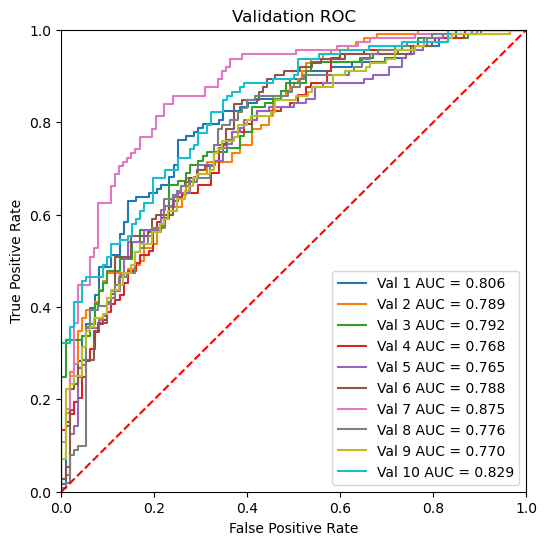

In [16]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

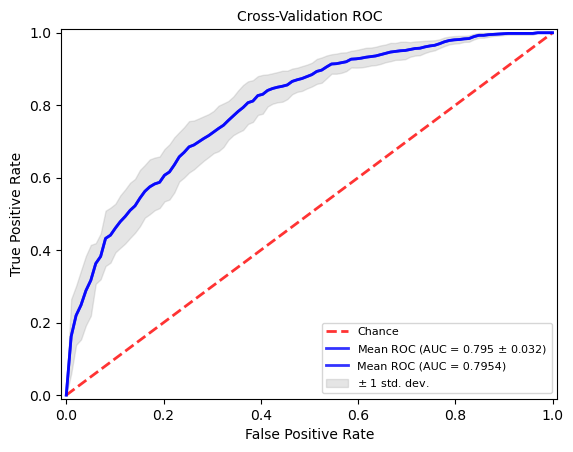

In [17]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [18]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [19]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [20]:
my_calculate_metrics_list_val

[{'SN': 0.8407079646017699,
  'SP': 0.5892857142857143,
  'ACC': 0.7155555555555555,
  'MCC': 0.44448908932885545,
  'Recall': 0.8407079646017699,
  'Precision': 0.6737588652482269,
  'F1-score': 0.7480314960629921,
  'Cutoff': 0.5},
 {'SN': 0.7946428571428571,
  'SP': 0.5625,
  'ACC': 0.6785714285714286,
  'MCC': 0.3671734096770158,
  'Recall': 0.7946428571428571,
  'Precision': 0.644927536231884,
  'F1-score': 0.712,
  'Cutoff': 0.5},
 {'SN': 0.672566371681416,
  'SP': 0.7321428571428571,
  'ACC': 0.7022222222222222,
  'MCC': 0.40538243565856796,
  'Recall': 0.672566371681416,
  'Precision': 0.7169811320754716,
  'F1-score': 0.6940639269406392,
  'Cutoff': 0.5},
 {'SN': 0.7787610619469026,
  'SP': 0.6339285714285714,
  'ACC': 0.7066666666666667,
  'MCC': 0.41719713859077295,
  'Recall': 0.7787610619469026,
  'Precision': 0.6821705426356589,
  'F1-score': 0.7272727272727273,
  'Cutoff': 0.5},
 {'SN': 0.831858407079646,
  'SP': 0.5267857142857143,
  'ACC': 0.68,
  'MCC': 0.376795737285

In [21]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.840708,0.589286,0.715556,0.444489,0.840708,0.673759,0.748031,0.5
1,0.794643,0.562500,0.678571,0.367173,0.794643,0.644928,0.712000,0.5
2,0.672566,0.732143,0.702222,0.405382,0.672566,0.716981,0.694064,0.5
3,0.778761,0.633929,0.706667,0.417197,0.778761,0.682171,0.727273,0.5
4,0.831858,0.526786,0.680000,0.376796,0.831858,0.639456,0.723077,0.5
5,0.892857,0.548673,0.720000,0.469898,0.892857,0.662252,0.760456,0.5
6,0.857143,0.716814,0.786667,0.579478,0.857143,0.750000,0.800000,0.5
7,0.857143,0.513274,0.684444,0.394217,0.857143,0.635762,0.730038,0.5
8,0.794643,0.619469,0.706667,0.420472,0.794643,0.674242,0.729508,0.5
9,0.821429,0.651786,0.736607,0.480174,0.821429,0.702290,0.757202,0.5


In [22]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.840708,0.589286,0.715556,0.444489,0.840708,0.673759,0.748031,0.5
1,0.794643,0.562500,0.678571,0.367173,0.794643,0.644928,0.712000,0.5
2,0.672566,0.732143,0.702222,0.405382,0.672566,0.716981,0.694064,0.5
3,0.778761,0.633929,0.706667,0.417197,0.778761,0.682171,0.727273,0.5
4,0.831858,0.526786,0.680000,0.376796,0.831858,0.639456,0.723077,0.5
5,0.892857,0.548673,0.720000,0.469898,0.892857,0.662252,0.760456,0.5
6,0.857143,0.716814,0.786667,0.579478,0.857143,0.750000,0.800000,0.5
7,0.857143,0.513274,0.684444,0.394217,0.857143,0.635762,0.730038,0.5
8,0.794643,0.619469,0.706667,0.420472,0.794643,0.674242,0.729508,0.5
9,0.821429,0.651786,0.736607,0.480174,0.821429,0.702290,0.757202,0.5


In [23]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [24]:
#遍历表格求初始里程
#独立测试
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [25]:
roc_auc_list_indep

[0.8038903061224489,
 0.8018973214285714,
 0.8137755102040817,
 0.8060427295918366,
 0.793845663265306,
 0.798469387755102,
 0.7790975765306123,
 0.8224649234693878,
 0.8121811224489794,
 0.8033322704081632]

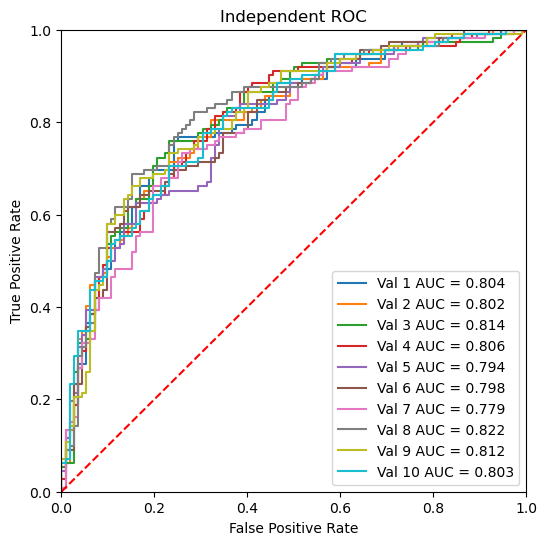

In [26]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

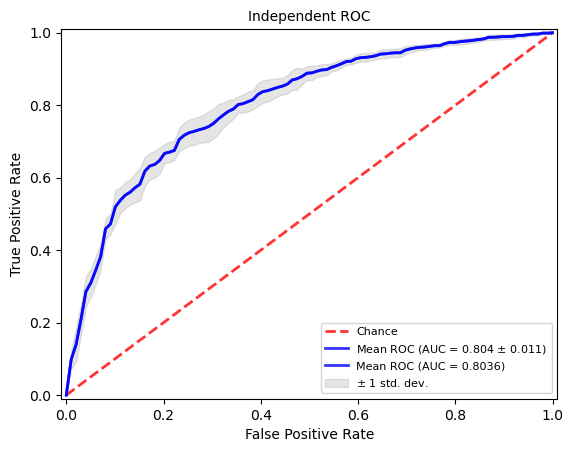

In [27]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [28]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [29]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [30]:
my_calculate_metrics_list_indep

[{'SN': 0.8303571428571429,
  'SP': 0.5625,
  'ACC': 0.6964285714285714,
  'MCC': 0.4077571434211702,
  'Recall': 0.8303571428571429,
  'Precision': 0.6549295774647887,
  'F1-score': 0.7322834645669292,
  'Cutoff': 0.5},
 {'SN': 0.8482142857142857,
  'SP': 0.5714285714285714,
  'ACC': 0.7098214285714286,
  'MCC': 0.4367041607814807,
  'Recall': 0.8482142857142857,
  'Precision': 0.6643356643356644,
  'F1-score': 0.7450980392156863,
  'Cutoff': 0.5},
 {'SN': 0.6517857142857143,
  'SP': 0.8125,
  'ACC': 0.7321428571428571,
  'MCC': 0.470400463163761,
  'Recall': 0.6517857142857143,
  'Precision': 0.776595744680851,
  'F1-score': 0.7087378640776699,
  'Cutoff': 0.5},
 {'SN': 0.7857142857142857,
  'SP': 0.6696428571428571,
  'ACC': 0.7276785714285714,
  'MCC': 0.4584559064750046,
  'Recall': 0.7857142857142857,
  'Precision': 0.704,
  'F1-score': 0.7426160337552743,
  'Cutoff': 0.5},
 {'SN': 0.8125,
  'SP': 0.6339285714285714,
  'ACC': 0.7232142857142857,
  'MCC': 0.4537212554003923,
  'Re

In [31]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.830357,0.562500,0.696429,0.407757,0.830357,0.654930,0.732283,0.5
1,0.848214,0.571429,0.709821,0.436704,0.848214,0.664336,0.745098,0.5
2,0.651786,0.812500,0.732143,0.470400,0.651786,0.776596,0.708738,0.5
3,0.785714,0.669643,0.727679,0.458456,0.785714,0.704000,0.742616,0.5
4,0.812500,0.633929,0.723214,0.453721,0.812500,0.689394,0.745902,0.5
5,0.875000,0.500000,0.687500,0.404520,0.875000,0.636364,0.736842,0.5
6,0.767857,0.660714,0.714286,0.431053,0.767857,0.693548,0.728814,0.5
7,0.848214,0.642857,0.745536,0.501766,0.848214,0.703704,0.769231,0.5
8,0.767857,0.705357,0.736607,0.474141,0.767857,0.722689,0.744589,0.5
9,0.785714,0.660714,0.723214,0.449958,0.785714,0.698413,0.739496,0.5


In [32]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.830357,0.562500,0.696429,0.407757,0.830357,0.654930,0.732283,0.5
1,0.848214,0.571429,0.709821,0.436704,0.848214,0.664336,0.745098,0.5
2,0.651786,0.812500,0.732143,0.470400,0.651786,0.776596,0.708738,0.5
3,0.785714,0.669643,0.727679,0.458456,0.785714,0.704000,0.742616,0.5
4,0.812500,0.633929,0.723214,0.453721,0.812500,0.689394,0.745902,0.5
5,0.875000,0.500000,0.687500,0.404520,0.875000,0.636364,0.736842,0.5
6,0.767857,0.660714,0.714286,0.431053,0.767857,0.693548,0.728814,0.5
7,0.848214,0.642857,0.745536,0.501766,0.848214,0.703704,0.769231,0.5
8,0.767857,0.705357,0.736607,0.474141,0.767857,0.722689,0.744589,0.5
9,0.785714,0.660714,0.723214,0.449958,0.785714,0.698413,0.739496,0.5


In [33]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Ubi\base_data_NEDD_Ubi\data_5k\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

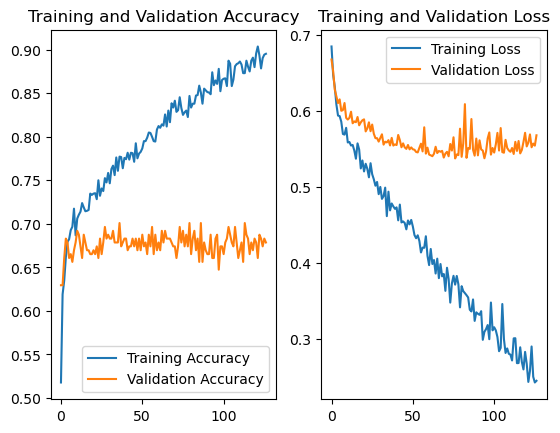

In [35]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()